In [1]:
import os
import sys
from importlib import reload
from pathlib import Path

import numpy as np
from torch.nn import ReLU, Linear
from torch_geometric.nn import GCNConv

In [2]:
# NOTE: Boilerplate setup for Jupyter imports

root = Path(os.getcwd()).parent
sys.path.append(
    (root / "src").as_posix()
)

import schema.configs as config_module
import enhancer as enhancer_module
import strategies as encoders_module
import schema.task as edges_module
import schema.data as data_module
import utils.metrics as utils_module

reload(edges_module)
reload(config_module)
reload(enhancer_module)
reload(encoders_module)
reload(data_module)
reload(utils_module)

PathConfig, TrainConfig, NetworkConfig = config_module.PathConfig, config_module.TrainConfig, config_module.NetworkConfig
Enhancer = enhancer_module.Enhancer
get_default_encoders = encoders_module.get_default_encoders
EnhancerData = data_module.EnhancerData
Task = edges_module.Task
euclid_metric, haversine_metric = utils_module.euclid_dist, utils_module.haversine_dist
TrainConfig = config_module.TrainConfig

In [3]:
from torch import from_numpy
from torch_geometric.nn import SAGEConv
from utils.metrics import euclid_dist
from sklearn.metrics import mean_squared_error

path_config = PathConfig(data_root="../data")
path_config.target_data = path_config.data_root / "processed/np/melbourne.npz"
with open(path_config.target_data, "rb") as f:
    unpacked = np.load(f)

    # NOTE: Target dimensions
    data = EnhancerData(
        from_numpy(unpacked["data"]     .astype(np.float32)),
        from_numpy(unpacked["target"]   .astype(np.float32)),
        from_numpy(unpacked["spatial"]  .astype(np.float32)),
    )

In [4]:
train_config = TrainConfig()

gnn_setup = NetworkConfig(
    encoder=[
        (
            SAGEConv(data.features.shape[1], 256),
            "x, edge_index -> x",
        ),
        (
            SAGEConv(256, 256),
            "x, edge_index -> x",
        ),
    ],
    estimator=[
        Linear(256, 128),
        ReLU(),
        Linear(128, 128),
        ReLU(),
        Linear(128, 1),
    ]
)

In [5]:
knn_strategy = encoders_module.KNNStrategy(
    K=5,
    dist_metric=euclid_dist,
    cache_dir=path_config.edge_cache,
    cache_id="melbourne_knn",
)

threshold_strategy = encoders_module.ThresholdStrategy(
    dist_metric=haversine_metric,
    max_dist=5,
    cache_dir=path_config.edge_cache,
    cache_id="melbourne_threshold",
)

input_tasks = [
    Task(knn_strategy, data),
    Task(threshold_strategy, data),
]

## Comparison

In [6]:
import torch
from sklearn.model_selection import train_test_split

dataset = torch.hstack((data.features, data.spatial, data.target))
train_dataset, test_dataset = train_test_split(dataset, train_size=0.8)

train_data = EnhancerData(
    features=train_dataset[:, :-3],
    spatial=train_dataset[:, -3:-1],
    target=train_dataset[:, -1],
)
test_data = EnhancerData(
    features=test_dataset[:, :-3],
    spatial=test_dataset[:, -3:-1],
    target=test_dataset[:, -1],
)

In [7]:
result = Enhancer.compare_strategies(
    train_data,
    test_data,
    gnn_setup,
    train_config,
    [knn_strategy, threshold_strategy],
)

GNN training: 100%|██████████| 10/10 [01:42<00:00, 10.23s/epoch, train_loss=2.47e+11]


In [8]:
import json

print(
    json.dumps(
        result.get_comparison([mean_squared_error]),
        indent="\t",
    )
)

{
	"melbourne_knn": {
		"mean_squared_error": 1082383597568.0,
		"density": 0.00040169204713229345,
		"average degree": 6.190877830402907,
		"n connected components": 19,
		"largest component": 14139
	},
	"melbourne_threshold": {
		"mean_squared_error": 224202981376.0,
		"density": 0.08119691067737335,
		"average degree": 1251.3255904490009,
		"n connected components": 4,
		"largest component": 15229
	}
}


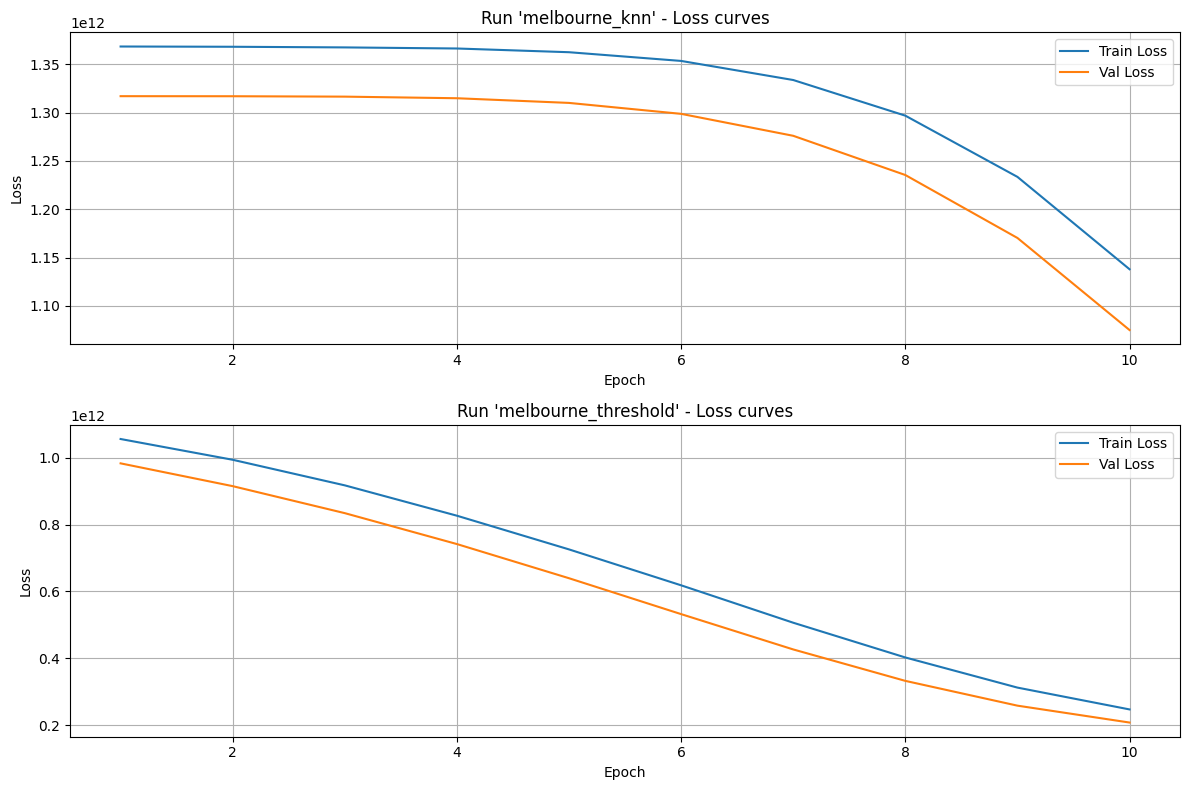

In [9]:
result.plot_train_logs()

## Processing

In [10]:
result = Enhancer.process_tasks(gnn_setup, train_config, input_tasks)

GNN training: 100%|██████████| 10/10 [00:17<00:00,  1.73s/epoch, train_loss=1.72e+11]


In [11]:
result._runs

[('melbourne_knn',
  tensor([[941000.],
          [750000.],
          [457000.],
          ...,
          [810000.],
          [815000.],
          [640000.]]),
  array([[ 371477.03],
         [1496538.4 ],
         [ 714792.9 ],
         ...,
         [1020800.6 ],
         [1802718.  ],
         [1315971.8 ]], dtype=float32),
  tensor([[   0,    0,    0,  ..., 3853, 3853, 3853],
          [ 374, 2237, 2557,  ..., 3426, 3622, 3647]]),
  [(635254025260.8384, 648826388480.0),
   (572532811836.1974, 589276250112.0),
   (518728457796.7229, 536225644544.0),
   (472187190562.4374, 488826568704.0),
   (431956368661.4033, 447267962880.0),
   (397526141721.58496, 411098906624.0),
   (367322236386.2555, 379795341312.0),
   (341862750819.8634, 352392904704.0),
   (319336886326.08527, 327641235456.0),
   (298130732001.9689, 304892575744.0)]),
 ('melbourne_threshold',
  tensor([[1315000.],
          [1135000.],
          [1180000.],
          ...,
          [ 810000.],
          [ 900000.],
     

In [12]:
print(result.get_comparison([mean_squared_error]))

{'melbourne_knn': {'mean_squared_error': 294308773888.0, 'density': 0.0015988458033025035, 'average degree': 6.160352880124546, 'n connected components': 4, 'largest component': 3674}, 'melbourne_threshold': {'mean_squared_error': 153781501952.0, 'density': 0.07787474743554604, 'average degree': 299.97352712172335, 'n connected components': 3, 'largest component': 3797}}


## Transformations

In [13]:
enhancer = Enhancer(
    gnn_setup, train_config, knn_strategy
)

In [14]:
gnn, _ = enhancer.fit(data)
transformed_data = enhancer.transform(data)

GNN training: 100%|██████████| 10/10 [00:05<00:00,  1.71epoch/s, train_loss=1.22e+11]


In [15]:
edge_index = knn_strategy(data.spatial)

In [16]:
gnn.predict(data.features, edge_index)

tensor([[1048385.4375],
        [1018871.6250],
        [1335859.5000],
        ...,
        [ 928599.6250],
        [ 718175.6875],
        [ 772007.6250]])

In [17]:
transformed_data.shape

(19267, 256)